첫날의 답변 활동량이 잔존 여부에 영향을 주는가??

In [6]:
import pandas as pd
import os

# 데이터 디렉토리
data_dir = "/home/jovyan/work/data"

all_data = []

# 각 테이블에서 데이터 추출
tables = [
    ('accounts_blockrecord_processed.csv', 'user_id'),
    ('accounts_failpaymenthistory.csv', 'user_id'),
    ('accounts_paymenthistory.csv', 'user_id'),
    ('accounts_pointhistory.csv', 'user_id'),
    ('accounts_timelinereport.csv', 'user_id'),
    ('accounts_user_processed.csv', 'id'),  # id가 user_id 역할
    ('accounts_userquestionrecord_processed.csv', 'user_id'),
    ('event_receipts.csv', 'user_id'),
    ('polls_questionreport.csv', 'user_id'),
    ('polls_questionset.csv', 'user_id')
]

# 일반 테이블들 처리
for file_name, user_col in tables:
    df = pd.read_csv(os.path.join(data_dir, file_name))
    temp_df = df[[user_col, 'created_at']].copy()
    temp_df.columns = ['user_id', 'created_at']
    temp_df['table_name'] = file_name.replace('.csv', '')
    all_data.append(temp_df)

# 친구 요청 테이블 - 보낸 사람만 포함 (능동적 활동)
df_friend = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 보낸 사람만 (능동적 활동)
temp_send = df_friend[['send_user_id', 'created_at']].copy()
temp_send.columns = ['user_id', 'created_at']
temp_send['table_name'] = 'accounts_friendrequest_send'
all_data.append(temp_send)

# 모든 데이터 병합
merged_df = pd.concat(all_data, ignore_index=True)

# created_at을 datetime으로 변환
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], format='ISO8601', errors='coerce')

# null 값 제거
merged_df = merged_df.dropna(subset=['created_at'])

# user_id로 그룹화하고 created_at으로 정렬
merged_df = merged_df.sort_values(['user_id', 'created_at']).reset_index(drop=True)

print(f"총 {len(merged_df):,}개 레코드 병합 완료")
print(f"유니크 사용자 수: {merged_df['user_id'].nunique():,}")
print("\n테이블별 레코드 수:")
print(merged_df['table_name'].value_counts())

총 21,705,813개 레코드 병합 완료
유니크 사용자 수: 677,085

테이블별 레코드 수:
table_name
accounts_friendrequest_send              17147175
accounts_pointhistory                     2338918
accounts_userquestionrecord_processed     1217558
accounts_user_processed                    677085
polls_questionset                          158384
accounts_paymenthistory                     95140
polls_questionreport                        51424
accounts_blockrecord_processed              19449
event_receipts                                309
accounts_timelinereport                       208
accounts_failpaymenthistory                   163
Name: count, dtype: int64


In [7]:
# 사용자별 생존기간 계산
user_survival = merged_df.groupby('user_id').agg({
    'created_at': ['first', 'last', 'count']
}).reset_index()

# 컬럼명 정리
user_survival.columns = ['user_id', 'first_activity', 'last_activity', 'total_events']

print(f"사용자 생존기간 테이블 완성: {len(user_survival):,}명")
print(user_survival.head())

# 생존일 수 계산 (차이 in days)
user_survival['survival_days'] = (user_survival['last_activity'] - user_survival['first_activity']).dt.days

# 이탈 유저 (당일 유저): 1, 잔존 유저: 0
user_survival['is_churn'] = user_survival['survival_days'].apply(lambda x: 1 if x == 0 else 0)

print(user_survival['is_churn'].value_counts())
# 1: 이탈 (하루만 활동), 0: 잔존

사용자 생존기간 테이블 완성: 677,085명
   user_id             first_activity              last_activity  total_events
0   831956 2023-03-29 03:44:14.047130 2023-03-29 03:44:14.047130             1
1   831962 2023-03-29 05:18:56.162368 2023-07-13 07:51:59.000000             2
2   832151 2023-03-29 12:56:34.989468 2023-05-09 15:50:58.000000            11
3   832340 2023-03-29 12:56:35.020790 2023-05-11 00:51:26.000000            29
4   832520 2023-03-29 12:56:35.049311 2023-03-29 12:56:35.049311             1
is_churn
0    441629
1    235456
Name: count, dtype: int64


In [8]:
# 1. 질문/답변 데이터 불러오기
uq_df = pd.read_csv(
    os.path.join(data_dir, 'accounts_userquestionrecord_processed.csv'),
    usecols=['user_id', 'answer_status', 'created_at'],
    parse_dates=['created_at']
)
uq_df['user_id'] = uq_df['user_id'].astype(str)
uq_df['answered'] = (uq_df['answer_status'] == 'A').astype(int)

# 2. 유저별 첫 활동일 계산
first_day = uq_df.groupby('user_id')['created_at'].min().reset_index()
first_day.columns = ['user_id', 'first_day']
uq_df = pd.merge(uq_df, first_day, on='user_id', how='left')

# 3. 첫날 질문만 필터링
uq_df['date_only'] = uq_df['created_at'].dt.date
uq_df['first_day_only'] = uq_df['first_day'].dt.date
uq_day1 = uq_df[uq_df['date_only'] == uq_df['first_day_only']].copy()

# 4. 유저별 첫날 집계
agg_day1 = uq_day1.groupby('user_id').agg(
    answer_count_day1=('answered', 'sum'),
    received_count_day1=('answered', 'count')
).reset_index()
agg_day1['answer_rate_day1'] = agg_day1['answer_count_day1'] / agg_day1['received_count_day1']

# 5. 질문률 계산
mean_questions = agg_day1['received_count_day1'].mean()
agg_day1['question_rate_day1'] = agg_day1['received_count_day1'] / mean_questions

# 6. user_survival과 merge → final_df 완성
user_survival['user_id'] = user_survival['user_id'].astype(str)
final_df = pd.merge(agg_day1, user_survival[['user_id', 'is_churn']], on='user_id', how='left')

# 7. 첫날 답변 유무
final_df['has_answer_day1'] = final_df['answer_count_day1'].apply(lambda x: 1 if x > 0 else 0)


In [9]:
print(final_df.head())
print(final_df['is_churn'].value_counts())  # 잔존/당일 유저 분포 확인


   user_id  answer_count_day1  received_count_day1  answer_rate_day1  \
0  1001157                  0                    9          0.000000   
1  1001222                  0                    5          0.000000   
2  1001373                 17                   34          0.500000   
3  1001561                  3                   36          0.083333   
4  1001607                  5                   22          0.227273   

   question_rate_day1  is_churn  has_answer_day1  
0            0.312962         0                0  
1            0.173868         0                0  
2            1.182301         0                1  
3            1.251848         0                1  
4            0.765018         0                1  
is_churn
0    4833
1      16
Name: count, dtype: int64


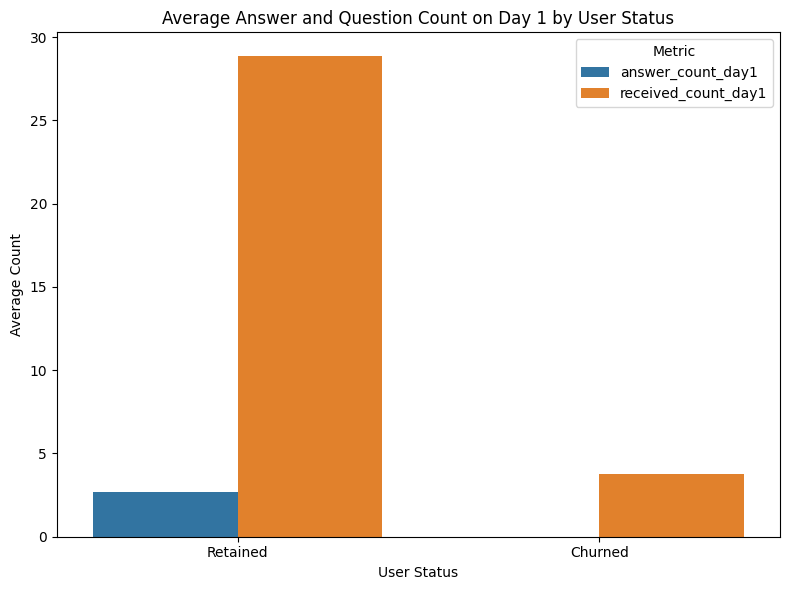

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 잔존/이탈 그룹별 첫날 답변 수, 질문 수 평균 계산
group_stats = final_df.groupby('is_churn')[['answer_count_day1', 'received_count_day1']].mean().reset_index()
group_stats['is_churn'] = group_stats['is_churn'].map({0: 'Retained', 1: 'Churned'})

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(data=group_stats.melt(id_vars='is_churn'), x='is_churn', y='value', hue='variable')

plt.title('Average Answer and Question Count on Day 1 by User Status')
# 제목: 잔존/이탈 유저의 첫날 질문 수 및 답변 수 평균 비교
plt.xlabel('User Status')
# x축: 사용자 상태 (Retained: 잔존, Churned: 이탈)
plt.ylabel('Average Count')
# y축: 평균 수
plt.legend(title='Metric')
# 범례: 지표 (answer_count_day1: 첫날 답변 수, received_count_day1: 첫날 질문 수)

plt.tight_layout()
plt.show()


In [15]:
# 전체 유저 평균 계산
overall_means = final_df[['answer_count_day1', 'received_count_day1', 'answer_rate_day1', 'question_rate_day1']].mean()

# 잔존 유저 평균 계산 (is_churn = 0)
retained_means = final_df[final_df['is_churn'] == 0][['answer_count_day1', 'received_count_day1', 'answer_rate_day1', 'question_rate_day1']].mean()

# 이탈 유저 평균 계산 (is_churn = 1)
churned_means = final_df[final_df['is_churn'] == 1][['answer_count_day1', 'received_count_day1', 'answer_rate_day1', 'question_rate_day1']].mean()

# 결과 출력
print('📊 전체 유저 평균')
print(f'  📌 첫날 답변 수: {overall_means["answer_count_day1"]:.2f}')
print(f'  📌 첫날 질문 수: {overall_means["received_count_day1"]:.2f}')
print(f'  📌 첫날 답변률: {overall_means["answer_rate_day1"]:.4f}')
print(f'  📌 첫날 질문률: {overall_means["question_rate_day1"]:.4f}')

print('\n🟢 잔존 유저 평균')
print(f'  📌 첫날 답변 수: {retained_means["answer_count_day1"]:.2f}')
print(f'  📌 첫날 질문 수: {retained_means["received_count_day1"]:.2f}')
print(f'  📌 첫날 답변률: {retained_means["answer_rate_day1"]:.4f}')
print(f'  📌 첫날 질문률: {retained_means["question_rate_day1"]:.4f}')

print('\n🔴 이탈 유저 평균')
print(f'  📌 첫날 답변 수: {churned_means["answer_count_day1"]:.2f}')
print(f'  📌 첫날 질문 수: {churned_means["received_count_day1"]:.2f}')
print(f'  📌 첫날 답변률: {churned_means["answer_rate_day1"]:.4f}')
print(f'  📌 첫날 질문률: {churned_means["question_rate_day1"]:.4f}')



📊 전체 유저 평균
  📌 첫날 답변 수: 2.70
  📌 첫날 질문 수: 28.76
  📌 첫날 답변률: 0.0976
  📌 첫날 질문률: 1.0000

🟢 잔존 유저 평균
  📌 첫날 답변 수: 2.71
  📌 첫날 질문 수: 28.84
  📌 첫날 답변률: 0.0979
  📌 첫날 질문률: 1.0029

🔴 이탈 유저 평균
  📌 첫날 답변 수: 0.00
  📌 첫날 질문 수: 3.75
  📌 첫날 답변률: 0.0000
  📌 첫날 질문률: 0.1304


In [16]:
# 질문 수 기준 구간화 (예시: 0, 1~9, 10~29, 30+)
bins = [-1, 0, 9, 29, 999]
labels = ['0', '1-9', '10-29', '30+']
final_df['question_bin'] = pd.cut(final_df['received_count_day1'], bins=bins, labels=labels)

# 각 구간별 잔존률 확인
print(pd.crosstab(final_df['question_bin'], final_df['is_churn'], normalize='index'))


is_churn             0         1
question_bin                    
1-9           0.987558  0.012442
10-29         1.000000  0.000000
30+           1.000000  0.000000


In [18]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, chi2
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.formula.api import ols
import statsmodels.api as sm

# 데이터 구성
data = {
    'question_bin': ['1-9', '10-29', '30+'],
    'churn_0': [0.987558, 1.0, 1.0],
    'churn_1': [0.012442, 0.0, 0.0],
    'total': [1.0, 1.0, 1.0]
}

# 비율 → 실수치로 환산 (비율에 맞는 임의의 총수 사용: 1000명)
total_counts = [1000, 1000, 1000]
observed = np.array([
    [int(0.987558 * 1000), int(0.012442 * 1000)],
    [1000, 0],
    [1000, 0]
])

# 카이제곱 검정
chi2_stat, p_val_chi2, dof, expected = chi2_contingency(observed)

# 트렌드 검정 (Cochran-Armitage Trend Test 비슷한 구조로)
# 잔존률만 사용하여 단순 선형회귀 (질문수 구간에 따른 잔존률)
trend_data = pd.DataFrame({
    'bin_numeric': [1, 2, 3],
    'churn_rate': [0.012442, 0.0, 0.0]  # 이탈률
})

trend_data['survive_rate'] = 1 - trend_data['churn_rate']
trend_model = ols('survive_rate ~ bin_numeric', data=trend_data).fit()
trend_pval = trend_model.pvalues['bin_numeric']

chi2_stat, p_val_chi2, trend_pval


(24.12053834886108, 5.7848439395126696e-06, 0.33333333333334314)

In [23]:
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm

# ✅ 카이제곱 검정
ct = pd.crosstab(final_df['question_bin'], final_df['is_churn'])
chi2, p, dof, expected = chi2_contingency(ct)

print('📊 카이제곱 검정 (Chi-Square Test)')
print(f'χ² 통계량: {chi2:.2f}')
print(f'p-value: {p:.10f}')
if p < 0.05:
    print('\n✅ 해석: 질문 수 구간과 이탈률 간의 연관성이 유의미하게 존재합니다.')
else:
    print('\n❌ 해석: 질문 수 구간과 이탈률 간의 유의미한 연관성이 없습니다.')

# ✅ 트렌드 검정 (선형 회귀 기반)
# 질문 구간을 숫자로 인코딩
trend_df = final_df.dropna(subset=['question_bin']).copy()
trend_df['question_bin_code'] = trend_df['question_bin'].cat.codes  # 0='0', 1='1-9', 2='10-29', 3='30+'

model = sm.OLS(trend_df['is_churn'], sm.add_constant(trend_df['question_bin_code'])).fit()
p_trend = model.pvalues[1]

print('\n📈 트렌드 검정 (선형 회귀 기반)')
print(f'p-value: {p_trend:.10f}')
if p_trend < 0.05:
    print('\n✅ 해석: 질문 수 구간 증가에 따라 이탈률에 선형적인 변화가 있습니다.')
else:
    print('\n❌ 해석: 질문 수 구간 증가에 따른 이탈률 변화는 선형적인 추세라고 보기 어렵습니다.')


📊 카이제곱 검정 (Chi-Square Test)
χ² 통계량: 44.48
p-value: 0.0000000002

✅ 해석: 질문 수 구간과 이탈률 간의 연관성이 유의미하게 존재합니다.

📈 트렌드 검정 (선형 회귀 기반)
p-value: 0.0000000201

✅ 해석: 질문 수 구간 증가에 따라 이탈률에 선형적인 변화가 있습니다.


/tmp/ipykernel_4791/3947121821.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_trend = model.pvalues[1]


/tmp/ipykernel_4791/2343396417.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_bin = 1 - final_df.groupby('question_bin')['is_churn'].mean().reindex(['0', '1-9', '10-29', '30+'])
posx and posy should be finite values
posx and posy should be finite values


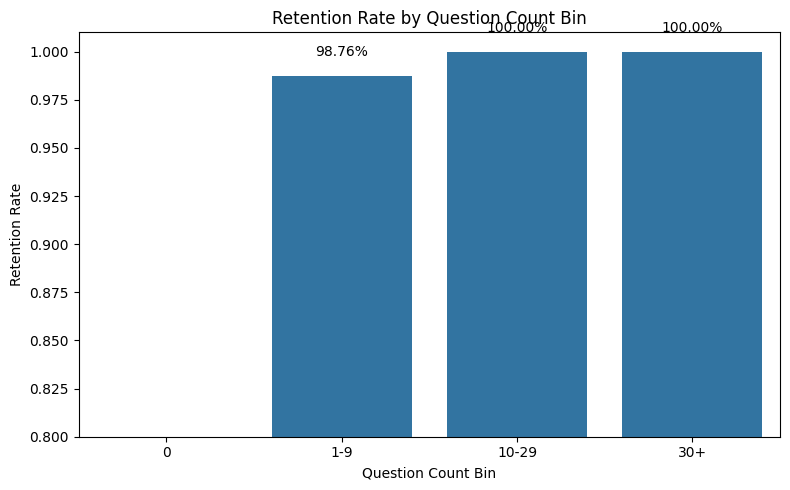

In [26]:
# 질문 수 구간별 잔존률 계산
retention_by_bin = 1 - final_df.groupby('question_bin')['is_churn'].mean().reindex(['0', '1-9', '10-29', '30+'])

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=retention_by_bin.index, y=retention_by_bin.values)

plt.title('Retention Rate by Question Count Bin')  # 질문 수 구간별 잔존률
plt.xlabel('Question Count Bin')
plt.ylabel('Retention Rate')

for i, val in enumerate(retention_by_bin.values):
    plt.text(i, val + 0.01, f'{val:.2%}', ha='center')

plt.ylim(0.8, 1.01)  # 상단 강조
plt.tight_layout()
plt.show()



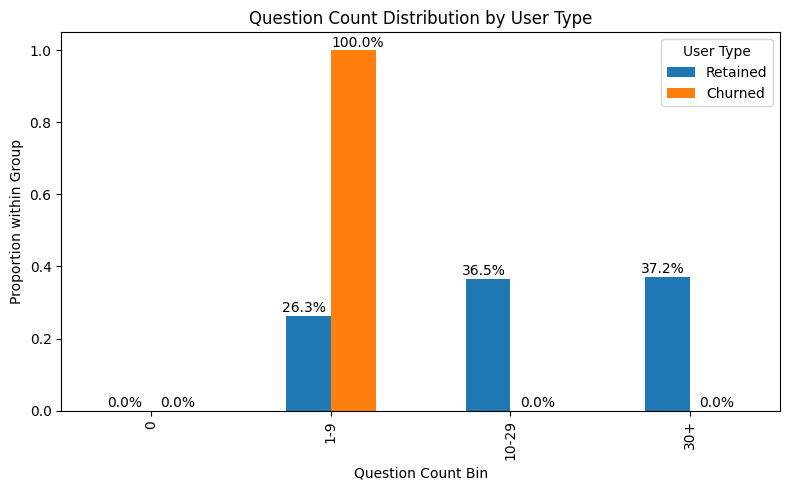

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 잔존/이탈 여부별로 질문 수 구간별 잔존률 계산
# is_churn == 0 → 잔존 유저만 필터링하여 질문 수 구간별 분포
# 전체 유저 기준 각 그룹에서 질문 수 구간 비율을 비교함

# 먼저 전체 유저 중 잔존/이탈로 나눠서 각 그룹 내 질문 수 구간 분포 계산
retained_dist = final_df[final_df['is_churn'] == 0]['question_bin'].value_counts(normalize=True).sort_index()
churned_dist = final_df[final_df['is_churn'] == 1]['question_bin'].value_counts(normalize=True).sort_index()

# 하나의 DataFrame으로 병합
compare_df = pd.DataFrame({
    'Retained': retained_dist,
    'Churned': churned_dist
}).reindex(['0', '1-9', '10-29', '30+'])  # 구간 순서 정렬

# 시각화
compare_df.plot(kind='bar', figsize=(8, 5))

plt.title('Question Count Distribution by User Type')  # 질문 수 구간별 잔존 vs 이탈 유저 비율
plt.xlabel('Question Count Bin')  # 질문 수 구간
plt.ylabel('Proportion within Group')  # 그룹 내 비율
plt.legend(title='User Type')

# 값 표시
for i in range(len(compare_df)):
    for j, val in enumerate(compare_df.iloc[i]):
        plt.text(i + (-0.15 if j == 0 else 0.15), val + 0.01, f'{val:.1%}', ha='center')

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

